In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d "suchintikasarkar/sentiment-analysis-for-mental-health"

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
  0% 0.00/11.1M [00:00<?, ?B/s]
100% 11.1M/11.1M [00:00<00:00, 1.27GB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/sentiment-analysis-for-mental-health.zip','r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification,BertTokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/Combined Data.csv',index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [ ]:
df.isnull().sum()

,0
statement,362
status,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,statement,status,new_statement,label
0,I can't stop feeling miserable. It's not even ...,Stress,can't stop feeling miserable. even ex going cr...,5
1,I feel like I am extremely unhappy with life. ...,Depression,feel like extremely unhappy life. mostly due c...,2
2,@greyseer Decently functional. I'm at work today.,Normal,@greyseer decently functional. work today.,3
3,stop thinking about what the point is.,Normal,stop thinking point is.,3
4,It makes me hate myself and i didn't do a damn...,Suicidal,makes hate damn thing,6
...,...,...,...,...
5995,I feel like years of depression and anxiety ma...,Depression,feel like years depression anxiety made brain ...,2
5996,Can you force yourself to talk to people? Two ...,Personality disorder,force talk people? two weeks ago would’ve swor...,4
5997,I feel so empty. I feel like I am machine. I a...,Suicidal,feel empty. feel like machine. sick repeating ...,6
5998,"You don't have to complicate things anymore, p...",Normal,"complicate things anymore, people",3


In [ ]:
df[df['status']=='Anxiety']

,statement,status,new_statement,label
29,People often say “Really?” when I tell them I ...,Anxiety,"people often say “really?” tell anxiety, mixed...",0
32,"Hip still swollen 4 months after fall, anxiety...",Anxiety,"hip still swollen 4 months fall, anxiety hangs...",0
56,another health scare so about an hour ago? i w...,Anxiety,"another health scare hour ago? would say, nowh...",0
58,DVT? So Ive had a cramp in my calf for the pas...,Anxiety,dvt? ive cramp calf past two days. first worri...,0
68,Can 24/7 anxiety cause brain-Tumor like sympto...,Anxiety,24/7 anxiety cause brain-tumor like symptoms? ...,0
...,...,...,...,...
5922,psychiatrist won’t do anything i went to the p...,Anxiety,psychiatrist won’t anything went psychiatrist ...,0
5931,Struggling with fear of breast cancer after se...,Anxiety,struggling fear breast cancer seeing multiple ...,0
5951,"Since then, the chicken cake has been restless...",Anxiety,"since then, chicken cake restless wants lay eggs.",0
5958,Thought I was finally getting over my brain tu...,Anxiety,thought finally getting brain tumour worry... ...,0


In [ ]:
df=df.sample(n=6000,random_state=42).reset_index(drop=True)

In [ ]:
df[['status','label']].value_counts()

,,count
status,label,
Normal,3,1888
Depression,2,1721
Suicidal,6,1246
Anxiety,0,420
Stress,5,301
Bipolar,1,292
Personality disorder,4,132


# Data Preprocessing

In [ ]:
nltk.download('stopwords')

stopwordss = set(stopwords.words("english"))

def clean_text(text):
  text=text.lower()
  text=re.sub(r'a-zA-Z\s','',text)
  words=text.split()
  words=[word for word in words if word not in stopwordss]
  return ' '.join(words)

df['new_statement']=df['statement'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
le=LabelEncoder()
df['label']=le.fit_transform(df['status'])

In [ ]:
X=df['new_statement']
y=df['label']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Tokentization

In [ ]:
model_name="bert-base-uncased"
tokenizer=BertTokenizer.from_pretrained(model_name)
train_encoding=tokenizer(list(X_train),truncation=True,max_length=128,padding=True,return_tensors='pt')
test_encoding=tokenizer(list(X_test),truncation=True,max_length=128,padding=True,return_tensors='pt')

In [ ]:
train_encoding.keys()


KeysView({'input_ids': tensor([[  101,  2215,  3102,  ...,     0,     0,     0],
        [  101,  9410, 10126,  ...,     0,     0,     0],
        [  101,  3058,  2197,  ...,     0,     0,     0],
        ...,
        [  101,  2488,  2706,  ...,     0,     0,     0],
        [  101,  6245,  5758,  ...,  1012,  2067,   102],
        [  101, 10089, 17901,  ..., 17901, 10663,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])})

In [ ]:
train_encoding['input_ids'][1]

tensor([  101,  9410, 10126,  1024,  5256,  2039,  1010,  2147,  1010,  2272,
         2188,  1010,  6457,  1010,  3913,  2793, 17186,  3042,  7858,  2067,
         2598,  2228,  2051,  4458,  2011,  1010,  2477,  2936,  5959,  2725,
         1010, 11675,  2572,  1012, 13499,  1024,  5256,  2039,  1010,  3913,
         2793, 28903,  3042,  2813,  5004, 23397,  1010,  3637,  1012,  3651,
         2589,  2498,  2627,  1018,  2086,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encoding),y_train.values))
val_dataset=tf.data.Dataset.from_tensor_slices((dict(test_encoding),y_test.values))


In [ ]:
train_dataset=train_dataset.shuffle(1000).batch(16)
val_dataset=val_dataset.batch(16)

# Model Building

In [ ]:
model_name = "bert-base-uncased"
num_labels = 7  # number of classes in output

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    from_pt=True,  # Explicitly specify to load from PyTorch weights
    local_files_only=False # Force re-download
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

# Train model

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=3)

Epoch 1/3
300/300 [==============================] - 202s 494ms/step - loss: 1.1292 - accuracy: 0.5702 - val_loss: 0.9664 - val_accuracy: 0.6300
Epoch 2/3
300/300 [==============================] - 137s 458ms/step - loss: 0.7299 - accuracy: 0.7169 - val_loss: 0.7313 - val_accuracy: 0.7225
Epoch 3/3
300/300 [==============================] - 134s 448ms/step - loss: 0.5189 - accuracy: 0.8117 - val_loss: 0.6478 - val_accuracy: 0.7608


In [ ]:
model.evaluate(val_dataset)

75/75 [==============================] - 11s 145ms/step - loss: 0.6478 - accuracy: 0.7608


[0.6478403806686401, 0.7608333230018616]

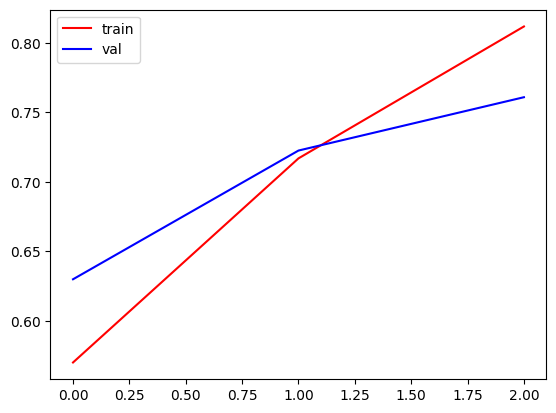

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='val')
plt.legend()
plt.show()

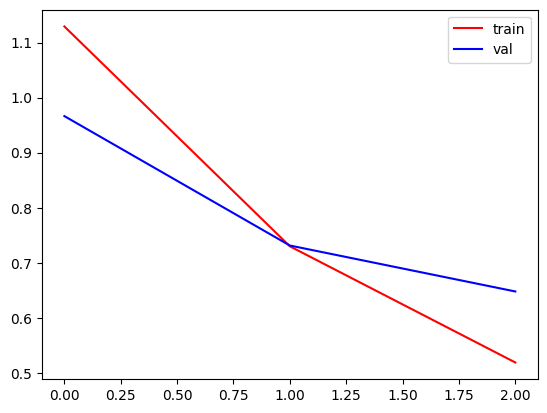

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='val')
plt.legend()
plt.show()

# Prediction

In [ ]:

inputs=tokenizer(text,truncation=True,padding=True,max_length=128,return_tensors='tf')
# outputs=model(**inputs)
# preds=tf.nn.softmax(outputs.logits,axis=-1)
# labels=np.argmax(preds,axis=1)


In [ ]:

inputs=tokenizer(text,truncation=True,padding=True,max_length=128,return_tensors='tf')
predictions=model.predict(inputs)
logits=predictions.logits
preds=tf.nn.softmax(logits,axis=-1)
labels=np.argmax(preds,axis=1)



1/1 [==============================] - 0s 101ms/step


In [ ]:

inputs=tokenizer(list(X_test),truncation=True,padding=True,max_length=128,return_tensors='tf')
predictions=model.predict(inputs)
logits=predictions.logits
preds=tf.nn.softmax(logits,axis=-1)
labels=np.argmax(preds,axis=1)

38/38 [==============================] - 15s 261ms/step


In [ ]:
print(preds.numpy())
print(labels)


[[0.00166424 0.00431005 0.49066827 ... 0.00692563 0.00673014 0.48819634]
 [0.00120517 0.00066834 0.00199869 ... 0.00129348 0.00246964 0.00421656]
 [0.43218136 0.07126669 0.23366465 ... 0.02316086 0.06340134 0.02757353]
 ...
 [0.01196087 0.0344451  0.00851128 ... 0.04366206 0.34104484 0.00871664]
 [0.02649754 0.08556739 0.038752   ... 0.1745552  0.65777355 0.01012765]
 [0.00103621 0.00249537 0.39898047 ... 0.00421458 0.00309965 0.5885257 ]]
[2 3 0 ... 3 5 6]


In [ ]:
y_test.values

array([5, 6, 3, ..., 1, 5, 6])

In [ ]:
y_pred

array([0, 2])

In [ ]:
cm=confusion_matrix(y_test,y_pred)

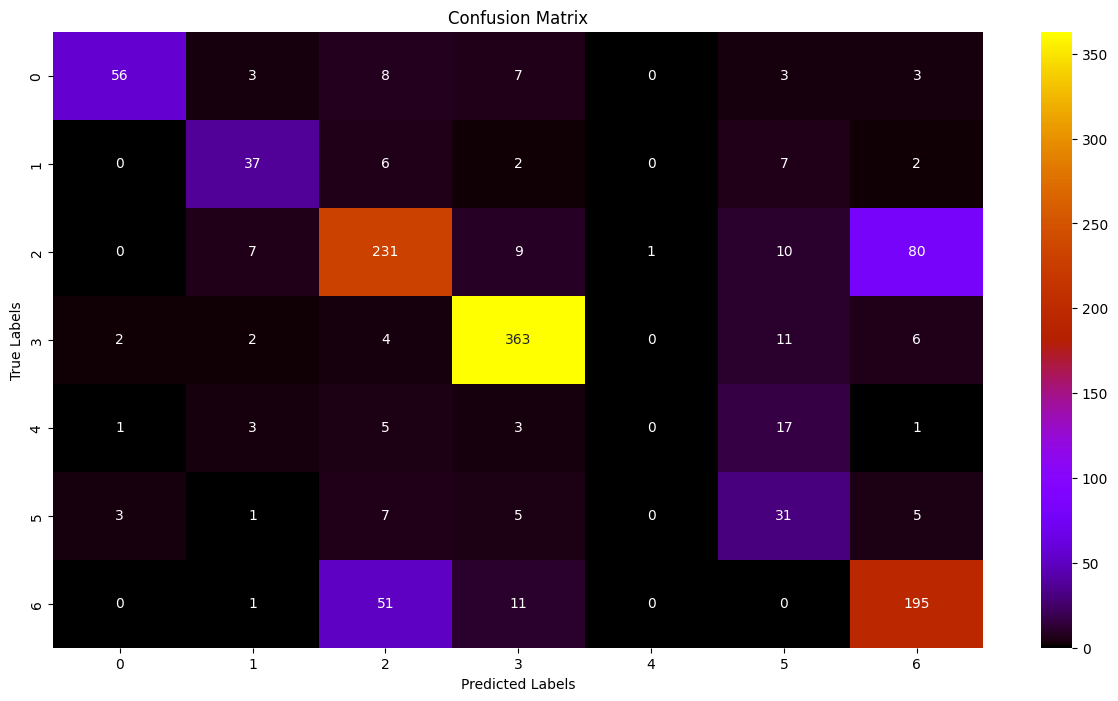

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='gnuplot')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df[['status','label']].value_counts()

,,count
status,label,
Normal,3,1888
Depression,2,1721
Suicidal,6,1246
Anxiety,0,420
Stress,5,301
Bipolar,1,292
Personality disorder,4,132


In [ ]:
text=["My anxiety is interfering with my job/school and personal relationships",
      "I have no energy; even small tasks feel like insurmountable chores"]
inputs=tokenizer(text,truncation=True,padding=True,max_length=128,return_tensors='tf')
predictions=model.predict(inputs)
logits=predictions.logits
preds=tf.nn.softmax(logits,axis=-1)
labels=np.argmax(preds,axis=1)
print(labels)

1/1 [==============================] - 0s 51ms/step
[0 2]
